# HIGGS ANALYSIS: 
### $H \to WW \to 2 \ell 2 \nu$ 
### (ggH) Production Mode

---

In [1]:
from datetime import datetime                                                         # For timestamp

print(f"Last modified: {datetime.now().strftime("%d %B %Y, %H:%M")}")                 # Print last modified date and time


Last modified: 07 October 2025, 19:59


### Dir setup

In [46]:
import os 
# Check the current directory
print("Current directory:", os.getcwd())

# Change to the folder containing NanoAOD ROOT files
os.chdir("C:\\MAIN\\HSF-India\\MC_samples_final")
# os.chdir("C:\\MAIN\\HSF-India\\Test_samples")

# Confirm the change
print("\nNew working directory:", os.getcwd())

for file in os.listdir():
    print(f'{file}')

Current directory: C:\MAIN\HSF-India\MC_samples_final

New working directory: C:\MAIN\HSF-India\MC_samples_final
DATA_MuonE_2016.root
Diboson.root
DY.root
files.txt
Higgs.root
Single_top.root
TTBar.root
Wjets.root


---

### Setting up imports

In [47]:
import uproot                          # For reading ROOT files                    
import awkward as ak                   # For handling jagged arrays
import numpy as np                     # For numerical operations
import matplotlib.pyplot as plt        # For plotting
import vector                          # For vector operations
from hist import Hist                  # For histogramming
from tqdm import tqdm                  # For progress bars
import gc                              # For garbage collection
%matplotlib inline                    
# %pip install prettytable
from prettytable import PrettyTable    # For displaying tables

# Register vector support for awkward arrays
vector.register_awkward()

### Samples collections

In [48]:

SAMPLES = {
    # "signal": {
    #     "color": "#EC2424",  # Strong red
    #     "is_signal": True,
    #     "stack_order": None
    # }
    # "DY_to_Tau_Tau": {
    #     "color": "#0C3AA5",  # Deep blue
    #     "is_signal": False,
    #     "stack_order": 0
    # },
    # "Wjets": {
    #     "color": "#23D9ED",  # Teal
    #     "is_signal": False,
    #     "stack_order": 1
    # },
    # "Top_antitop": {
    #     "color": "#29B829",  # Dark green
    #     "is_signal": False,
    #     "stack_order": 2
    # },
    # "Single_Top": {
    #     "color": "#B26EF1",  # Purple
    #     "is_signal": False,
    #     "stack_order": 3
    # },
    # "Diboson": {
    #     "color": "#DDB340",  # Mustard
    #     "is_signal": False,
    #     "stack_order": 4
    # }
    "Data": {
        "color": "#000000",  # Black for data
        "is_signal": False,
        "stack_order": 5
    }
}


In [49]:
# Extract colors for backward compatibility
colors = {key: value["color"] for key, value in SAMPLES.items()}


In [50]:
# %%
# Load file names from file
files = {}
with open("files.txt", "r") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        key, filename = line.split(maxsplit=1)
        files[key] = filename

print("Files to process:")
for key, file in files.items():
    print(f"{key}: {file}")

Files to process:
Data: DATA_MuonE_2016.root


---

### Helper functions


In [51]:
# %%
def wrap_angle_to_pi(angle):
    """More concise way to wrap angle to [-π, π] range"""
    return (angle + np.pi) % (2 * np.pi) - np.pi

def create_lepton_vector(lepton):
    """Create 4-vector from lepton properties - unified function"""
    return vector.array({
        "pt": lepton.pt,
        "eta": lepton.eta,
        "phi": lepton.phi,
        "mass": lepton.mass
    })

### Load events

In [52]:
# %%
def load_events(filename, batch_size=100_000):
    """Load events from a ROOT file in batches"""
    print(f"\nProcessing: {filename}")

    columns = [
        # Electrons
        "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
        "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
        # Muons
        "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
        "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
        # MET
        "MET_pt", "MET_phi",
        # Jets
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        "Jet_btagDeepFlavB", "nJet", "Jet_jetId", "Jet_puId",
    ]

    with uproot.open(filename) as f:
        tree = f['Events']
        total_entries = tree.num_entries
        print(f"Total events: {total_entries}")

        num_batches = (total_entries + batch_size - 1) // batch_size
        
        pbar = tqdm(
            tree.iterate(columns, step_size=batch_size, library="ak"),
            total=num_batches,
            desc="Processing batches",
            unit="batch",
            ncols=100
        )
        
        for batch_num, arrays in enumerate(pbar):
            pbar.set_postfix({
                'events': f"{len(arrays):,}",
                'batch': f"{batch_num + 1}/{num_batches}"
            })
            yield arrays

### select tight leptons


In [53]:

# %%
def select_tight_leptons(arrays):
    """Apply tight ID and isolation cuts to leptons"""
    # Define selection masks
    tight_electron_mask = arrays.Electron_mvaFall17V2Iso_WP90 == 1
    tight_muon_mask = (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15)
    
    # Create structured arrays for selected leptons
    tight_electrons = ak.zip({
        "pt": arrays.Electron_pt[tight_electron_mask],
        "eta": arrays.Electron_eta[tight_electron_mask],
        "phi": arrays.Electron_phi[tight_electron_mask],
        "mass": arrays.Electron_mass[tight_electron_mask],
        "charge": arrays.Electron_charge[tight_electron_mask],
        "flavor": ak.ones_like(arrays.Electron_pt[tight_electron_mask]) * 11
    })
    
    tight_muons = ak.zip({
        "pt": arrays.Muon_pt[tight_muon_mask],
        "eta": arrays.Muon_eta[tight_muon_mask],
        "phi": arrays.Muon_phi[tight_muon_mask],
        "mass": arrays.Muon_mass[tight_muon_mask],
        "charge": arrays.Muon_charge[tight_muon_mask],
        "flavor": ak.ones_like(arrays.Muon_pt[tight_muon_mask]) * 13
    })
    
    # Combine into single collection
    tight_leptons = ak.concatenate([tight_electrons, tight_muons], axis=1)
    
    return tight_leptons, tight_electron_mask, tight_muon_mask

### select e-mu events

In [54]:
def select_e_mu_events(tight_leptons, met_arrays, leading_pt_cut=25, subleading_pt_cut=15):
    """Select events with exactly 1 electron and 1 muon"""
    
    # Sort by pT
    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
    
    # Require at least 2 leptons
    mask_2lep = ak.num(sorted_leptons) == 2
    events_2lep = sorted_leptons[mask_2lep]
    met_2lep = met_arrays[mask_2lep]
    
    if len(events_2lep) == 0:
        return None, None, {}, None
    
    # Get leading and subleading
    leading = events_2lep[:, 0]
    subleading = events_2lep[:, 1]
    
    # Selection criteria
    mask_1e1mu = ((leading.flavor == 11) & (subleading.flavor == 13)) | \
                 ((leading.flavor == 13) & (subleading.flavor == 11))
    mask_opposite_charge = leading.charge * subleading.charge < 0
    mask_pt = (leading.pt > leading_pt_cut) & (subleading.pt > subleading_pt_cut)
    
    # Final selection
    final_mask = mask_1e1mu & mask_opposite_charge & mask_pt
    
    # Store cutflow information
    cutflow = {
        'events_2lep': len(leading),
        'events_1e1mu': ak.sum(mask_1e1mu),
        'events_opposite_charge': ak.sum(mask_1e1mu & mask_opposite_charge),
        'events_final': ak.sum(final_mask)
    }
    
    return leading[final_mask], subleading[final_mask], cutflow, met_2lep[final_mask]


### Calculate kinematic variables

In [55]:
def cal_kinematic_var(leading, subleading, met):

    lepton_1 = create_lepton_vector(leading)
    lepton_2 = create_lepton_vector(subleading)


    dilepton = lepton_1 + lepton_2

    masses = dilepton.mass
    ptll = dilepton.pt
    dphi = wrap_angle_to_pi(leading.phi - subleading.phi)


    mt_higgs_dphi = wrap_angle_to_pi(dilepton.phi - met.phi)
    mt_higgs = np.sqrt(2 * dilepton.pt * met.pt * (1 - np.cos(mt_higgs_dphi)))

    mt_l2_met_dphi = wrap_angle_to_pi(subleading.phi - met.phi)
    mt_l2_met = np.sqrt(2 * subleading.pt * met.pt * (1 - np.cos(mt_l2_met_dphi)))


    return masses, ptll, dphi, mt_higgs, mt_l2_met


### jet counting 

In [56]:

def count_jets(arrays, jet_pt_threshold=30, tight_leptons = None):
    """Select good jets, sort them by pt, and build jet category masks.
    Good jets: jetId >= 2 (Tight ID) AND pt > jet_pt_threshold.

    Returns
    -------
    n_jets : ak.Array
        Number of good jets per event (above pt threshold).
    good_mask : ak.Array
        Boolean mask applied on arrays.Jet.
    sorted_jets : ak.Array
        Good jets sorted by pt.
    isZeroJet : ak.Array
        Boolean mask per event (True = 0-jet category).
    isOneJet : ak.Array
        Boolean mask per event (True = 1-jet category).
    isTwoJet : ak.Array
        Boolean mask per event (True = >=2-jet category).
    """

    # Step 1: Create Jet object from individual arrays
    jets = ak.zip({
        "pt": arrays.Jet_pt,
        "eta": arrays.Jet_eta,
        "phi": arrays.Jet_phi,
        "mass": arrays.Jet_mass,
        "jetId": arrays.Jet_jetId,
        "btagDeepFlavB": arrays.Jet_btagDeepFlavB,
        "Jet_puId": arrays.Jet_puId
    })
    
    # Step 2: Good jet selection (Tight ID AND pt above threshold)
    pu_id_mask = (jets.pt > 50) | ((jets.pt <= 50) & (jets.Jet_puId >= 4))
    good_mask = (jets.jetId >= 2) & (abs(jets.phi)<4.7) & pu_id_mask
  
    if tight_leptons is None or ak.max(ak.num(tight_leptons)) == 0:
        return good_mask
    
    #  compute delta R between jets and leptons
    try:
        jets_eta = jets.eta[:, :, None]       
        jets_phi = jets.phi[:, :, None]
        leps_eta = tight_leptons.eta[:, None, :] 
        leps_phi = tight_leptons.phi[:, None, :]
        
        deta = jets_eta - leps_eta
        dphi = (jets_phi - leps_phi + np.pi) % (2*np.pi) - np.pi
        dr = np.sqrt(deta**2 + dphi**2)
        
        # Minimum delta R over all leptons for each jet
        min_dr = ak.min(dr, axis=-1)
        
        # Jets passing the delta R cut
        dr_cut_mask = min_dr > 0.4
        
        # Update good_mask
        good_mask = good_mask & dr_cut_mask
    
    except Exception as e:
        print(f"Warning: Lepton cleaning failed ({e}), skipping...")

    good_jets = jets[good_mask]
    
    # Step 3: Sort by pt
    order = ak.argsort(good_jets.pt, axis=1, ascending=False)
    sorted_jets = good_jets[order]

    lead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt),0)
    sublead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt[..., 1:]), 0)

    # Step 4: Count good jets above threshold
    # n_jets = ak.num(sorted_jets)
    
    # Step 5: Category masks based on jet count
    # isZeroJet = (n_jets == 0)
    # isOneJet = (n_jets == 1)
    # isTwoJet = (n_jets >= 2) # 2 or more jets

    isZeroJet = (lead_jet_pt < jet_pt_threshold)
    isOneJet = (lead_jet_pt >= jet_pt_threshold) & (sublead_jet_pt < jet_pt_threshold)
    isTwoJet = (sublead_jet_pt >= jet_pt_threshold)

    n_jets = ak.sum(sorted_jets.pt >= jet_pt_threshold, axis = 1)

    return n_jets, good_mask, sorted_jets, isZeroJet, isOneJet, isTwoJet

In [57]:
def apply_bjet_veto(arrays, bjet_pt_threshold=20, btag_threshold=0.2217, eta_max=2.5):
    """
    Apply b-jet veto. Returns True for events passing the veto (no b-jets).
    
    Criteria:
    - Jet passes tight ID (jetId >= 2)
    - pt > threshold
    - |eta| < eta_max
    - DeepFlavB discriminator > btag_threshold
    """

    # Select candidate b-jets
    bjet_mask = (
        (arrays.Jet_jetId >= 2) &
        (arrays.Jet_pt > bjet_pt_threshold) &
        (abs(arrays.Jet_eta) < eta_max) &
        (arrays.Jet_btagDeepFlavB > btag_threshold)
    )

    # Count number of b-jets per event
    n_bjets = ak.sum(bjet_mask, axis=1)

    # Event passes veto if no b-jets
    return n_bjets == 0


### Global cuts

In [58]:
def apply_global_cuts(leading, subleading, met, mt_higgs, mt_l2_met,ptlls,masses):
    """Apply global selection cuts"""
    # Global cuts
    mask_subleading_pt = subleading.pt >= 15 
    mask_mt_higgs = mt_higgs > 60
    mask_mt_l2_met = mt_l2_met > 30
    mask_met_pt = met.pt > 20
    mask_ptll  = ptlls > 30
    mask_mll = masses > 12 
    
    # Combine all masks
    global_mask = mask_mt_higgs & mask_mt_l2_met & mask_subleading_pt & mask_met_pt & mask_ptll & mask_mll

    return global_mask, {
        'pass_mt_higgs': ak.sum(mask_mt_higgs),
        'pass_mt_l2_met': ak.sum(mask_mt_l2_met),
        'pass_subleading_pt': ak.sum(mask_subleading_pt),
        'pass_met_pt': ak.sum(mask_met_pt),
        'pass_ptll': ak.sum(mask_ptll),
        'pass_mll': ak.sum(mask_mll),
        'pass_global': ak.sum(global_mask)
    }

In [59]:
# Initialize storage for different stages
def initialize_stage_storage():
    """Initialize storage for all selection stages"""
    return {
        'before_cuts': {},
        'global': {},
        '0jet': {},
        '1jet': {},
        '2jet': {}
    }

hist_data = {}
selected_leptons = {}
event_variables = {}

# Define binning
mass_bins = np.linspace(0, 200, 25)
met_bins = np.linspace(0, 200, 25)
dphi_bins = np.linspace(0, np.pi, 25)
ptll_bins = np.linspace(0, 200, 25)


stage_data = {}
for label in files.keys():
    stage_data[label] = initialize_stage_storage()


### Processing function


In [60]:
def process_file_unified(fname, label):    
    """Single processing function that handles all stages"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_collectors = {stage: {key: [] for key in 
                                ["mass", "met", "dphi", "ptll",
                                 "mt_higgs", "mt_l2_met",
                                 "leading", "subleading"]} 
                        for stage in stages}

    cutflow = {stage: 0 for stage in ['total', 'e_mu_preselection', 'global_cuts', '0jet', '1jet', '2jet']}

    
    print(f"\nProcessing: {fname}")
    
    # Process file in batches
    for arrays in load_events(fname, batch_size=100_000):
        cutflow['total'] += len(arrays)
        
        # Get tight leptons
        tight_leptons, _, _ = select_tight_leptons(arrays)
        met = ak.zip({"pt": arrays.MET_pt, "phi": arrays.MET_phi})
        
        # Apply e-mu selection
        leading, subleading, emu_cutflow, met_selected = select_e_mu_events(tight_leptons, met)
        
        if leading is None or len(leading) == 0:
            continue
            
        cutflow['e_mu_preselection'] += len(leading)
        
        # Calculate kinematic variables
        masses, ptlls, dphis, mt_higgs, mt_l2_met = cal_kinematic_var(leading, subleading, met_selected)
        
        
        for key, value in zip(stage_collectors['before_cuts'].keys(),
                              [masses, met_selected.pt, dphis, ptlls, mt_higgs, mt_l2_met, leading, subleading]):
            stage_collectors['before_cuts'][key].append(value)
        

        # === STAGE 2: GLOBAL CUTS ===
        # To align the jet information,  need to track which original events passed e-mu selection
        sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
        has_2lep = ak.num(sorted_leptons) == 2
        
        # Recreate the e-mu selection mask at event level
        events_2lep = sorted_leptons[has_2lep]
        if len(events_2lep) > 0:
            lead_all = events_2lep[:, 0]
            sublead_all = events_2lep[:, 1]
            
            mask_1e1mu = ((lead_all.flavor == 11) & (sublead_all.flavor == 13)) | \
                         ((lead_all.flavor == 13) & (sublead_all.flavor == 11))
            mask_charge = lead_all.charge * sublead_all.charge < 0
            mask_pt = (lead_all.pt > 25) & (sublead_all.pt > 15)
            
            emu_mask_2lep = mask_1e1mu & mask_charge & mask_pt
            
            # Map back to original indices
            indices_2lep = ak.where(has_2lep)[0]
            indices_emu = indices_2lep[emu_mask_2lep]
            
            # Apply global cuts
            global_cut_mask, _ = apply_global_cuts(leading, subleading, met_selected, mt_higgs, mt_l2_met,ptlls,masses)
            # mask_ptll  = ptlls > 30
            # mask_mll = masses > 12
            # global_cut_mask = global_cut_mask & mask_ptll & mask_mll

            
            # Apply b-jet veto
            bjet_veto_full = apply_bjet_veto(arrays)
            bjet_veto_selected = bjet_veto_full[indices_emu]
                   
            # Combine cuts
            global_mask_selected = global_cut_mask & bjet_veto_selected
            cutflow['global_cuts'] += ak.sum(global_mask_selected)
            
            if ak.sum(global_mask_selected) > 0:
                for key, value in zip(stage_collectors['global'].keys(),
                                                [masses, met_selected.pt, dphis, ptlls, mt_higgs, mt_l2_met, leading, subleading]):
                    stage_collectors['global'][key].append(value[global_mask_selected])
             

                
                # === STAGES 3-5: JET CATEGORIES ===
                # Count jets for full events 

                n_jets_full, _, _, isZeroJet_full, isOneJet_full, isTwoJet_full = count_jets(arrays, tight_leptons=tight_leptons)


                    # Map to selected events
                isZeroJet_selected = isZeroJet_full[indices_emu]
                isOneJet_selected = isOneJet_full[indices_emu]
                isTwoJet_selected = isTwoJet_full[indices_emu]

                # Apply jet categories with global cuts
                mask_0jet = global_mask_selected & isZeroJet_selected
                mask_1jet = global_mask_selected & isOneJet_selected
                mask_2jet = global_mask_selected & isTwoJet_selected

                
                cutflow['0jet'] += ak.sum(mask_0jet)
                cutflow['1jet'] += ak.sum(mask_1jet)
                cutflow['2jet'] += ak.sum(mask_2jet)
                
        
                for jet_cat, mask in [('0jet', mask_0jet), ('1jet', mask_1jet), ('2jet', mask_2jet)]:
                    if ak.sum(mask) > 0:
                        for key, value in zip(stage_collectors[jet_cat].keys(),
                                            [masses, met_selected.pt, dphis, ptlls, mt_higgs, mt_l2_met, leading, subleading]):
                            stage_collectors[jet_cat][key].append(value[mask])
        
        # Clear memory
        del arrays
        gc.collect()
    
    # Concatenate results
    final_data = {}
    for stage in stage_collectors:
        if stage_collectors[stage]["mass"]:
            final_data[stage] = {
                key: ak.concatenate(values) if values else ak.Array([])
                for key, values in stage_collectors[stage].items()
            }
        else:
            final_data[stage] = None

    final_data = {}
    for stage in stages:
        if stage_collectors[stage]["mass"]:
            final_data[stage] = {key: ak.concatenate(values) if values else ak.Array([])
                                 for key, values in stage_collectors[stage].items()}
     
    else:
        event_data = None
    
    return final_data, event_data, cutflow

### Main processing loop

In [61]:
# SINGLE PROCESSING LOOP
stage_data_final = {}

print("\n" + "="*60)
print("PROCESSING:")
print("="*60)

file_pbar = tqdm(files.items(), desc="Processing files", unit="file", ncols=100)

for label, fname in file_pbar:
    file_pbar.set_description(f"Processing {label}")
    
    try:
        # Process file once for all stages
        stage_data_final[label], event_variables[label], cutflow = process_file_unified(fname, label)
        
        # Print cutflow
        print(f"\n{label} Cutflow:")
        print(f"  Total events:       {cutflow['total']:,}")
        print(f"  e-μ preselection:   {cutflow['e_mu_preselection']:,}")
        print(f"  Global cuts:        {cutflow['global_cuts']:,}")
        print(f"  ├── 0-jet:          {cutflow['0jet']:,}")
        print(f"  ├── 1-jet:          {cutflow['1jet']:,}")
        print(f"  └── 2-jet:          {cutflow['2jet']:,}")
        
    except Exception as e:
        file_pbar.set_postfix({'ERROR': str(e)[:20]})
        print(f"\nError processing {fname}: {e}")
        import traceback
        traceback.print_exc()
        stage_data_final[label] = initialize_stage_storage()
        event_variables[label] = None

print("\nProcessing complete!")


PROCESSING:


Processing Data:   0%|                                                      | 0/1 [00:00<?, ?file/s]


Processing: DATA_MuonE_2016.root

Processing: DATA_MuonE_2016.root
Total events: 33854612


Processing Data: 100%|█████████████████████████████████████████████| 1/1 [09:25<00:00, 565.44s/file]


Data Cutflow:
  Total events:       33,854,612
  e-μ preselection:   138,059
  Global cuts:        11,958
  ├── 0-jet:          4,816
  ├── 1-jet:          3,568
  └── 2-jet:          3,574

Processing complete!


In [62]:
def plot_stage_comparison(variable, var_props, stage_data_all):
    """Create comparison plot across selection stages for a given variable"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        
        # Plot each sample
        for sample in files.keys():
            if sample in stage_data_all and stage_data_all[sample][stage] is not None:
                if variable in stage_data_all[sample][stage]:
                    data = ak.to_numpy(stage_data_all[sample][stage][variable])
                    
                    if len(data) > 0:
                        ax.hist(data, bins=var_props['bins'], 
                               histtype='step', linewidth=2 if SAMPLES[sample]["is_signal"] else 1.5,
                               label=sample, color=SAMPLES[sample]["color"], alpha=0.8, density=True)
        
        ax.set_xlabel(var_props['xlabel'], fontsize=10)
        ax.set_title(stage_label, fontsize=11, fontweight='bold')
        ax.set_xlim(var_props['xlim'])
        
        ax.legend(fontsize=8)
        if idx == 0:
            ax.set_ylabel('Random Units', fontsize=10)
        
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{variable.upper()} Distribution Across Selection Stages', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [63]:
# Create comparison plots for each sample and variable
variables_to_plot = {
    'mass': {'bins': np.linspace(0, 200, 30), 'xlabel': '$m_{e\\mu}$ [GeV]', 'xlim': (0, 200)},
    'met': {'bins': np.linspace(0, 200, 30), 'xlabel': '$E_T^{miss}$ [GeV]', 'xlim': (0, 200)},
    'dphi': {'bins': np.linspace(0, np.pi, 30), 'xlabel': '$\\Delta\\phi_{e\\mu}$ [rad]', 'xlim': (0, np.pi)},
    'ptll': {'bins': np.linspace(0, 200, 30), 'xlabel': '$p_T^{e\\mu}$ [GeV]', 'xlim': (0, 200)},
    'mt_higgs': {'bins': np.linspace(0, 250, 30), 'xlabel': '$m_T^{H}$ [GeV]', 'xlim': (0, 250)},
    'mt_l2_met': {'bins': np.linspace(0, 200, 30), 'xlabel': '$m_T(\\ell_2, E_T^{miss})$ [GeV]', 'xlim': (0, 200)}
}



Creating comparison plots...

Plotting mass...


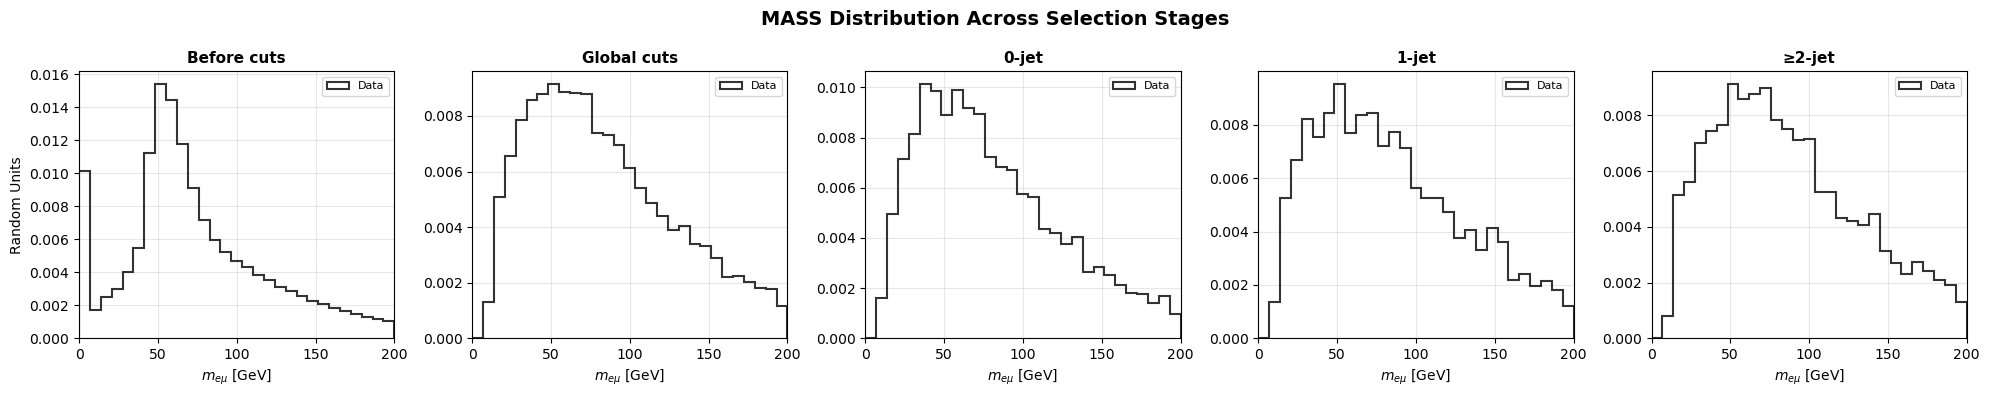


Plotting met...


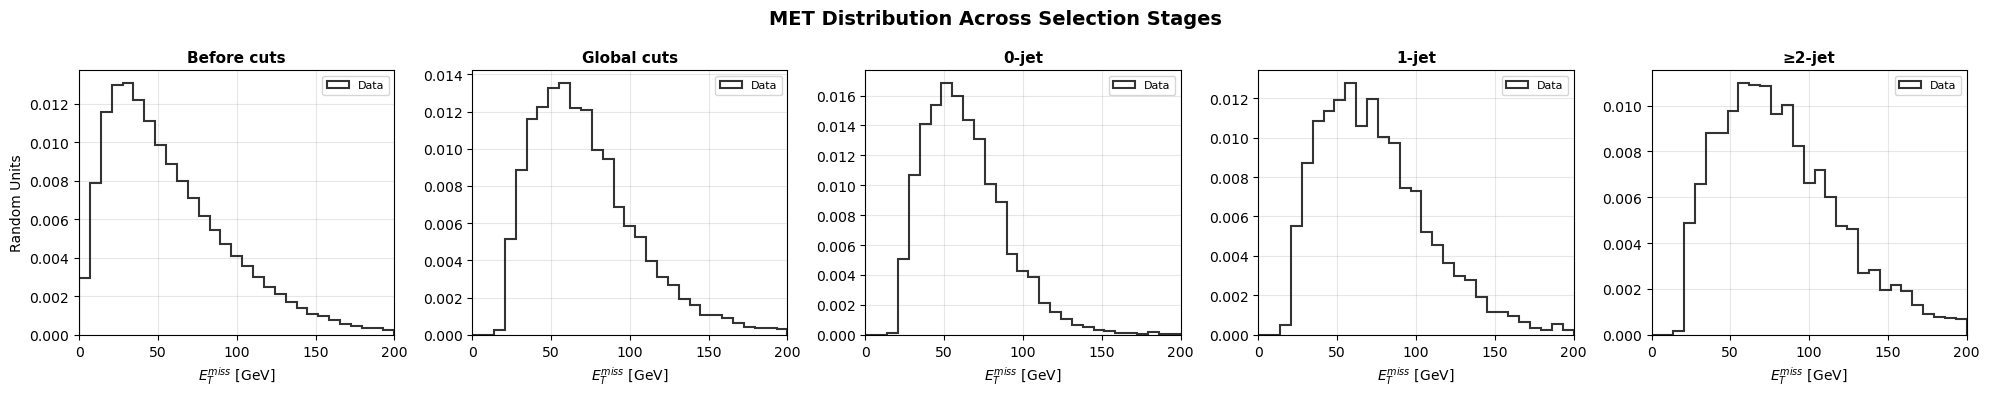


Plotting dphi...


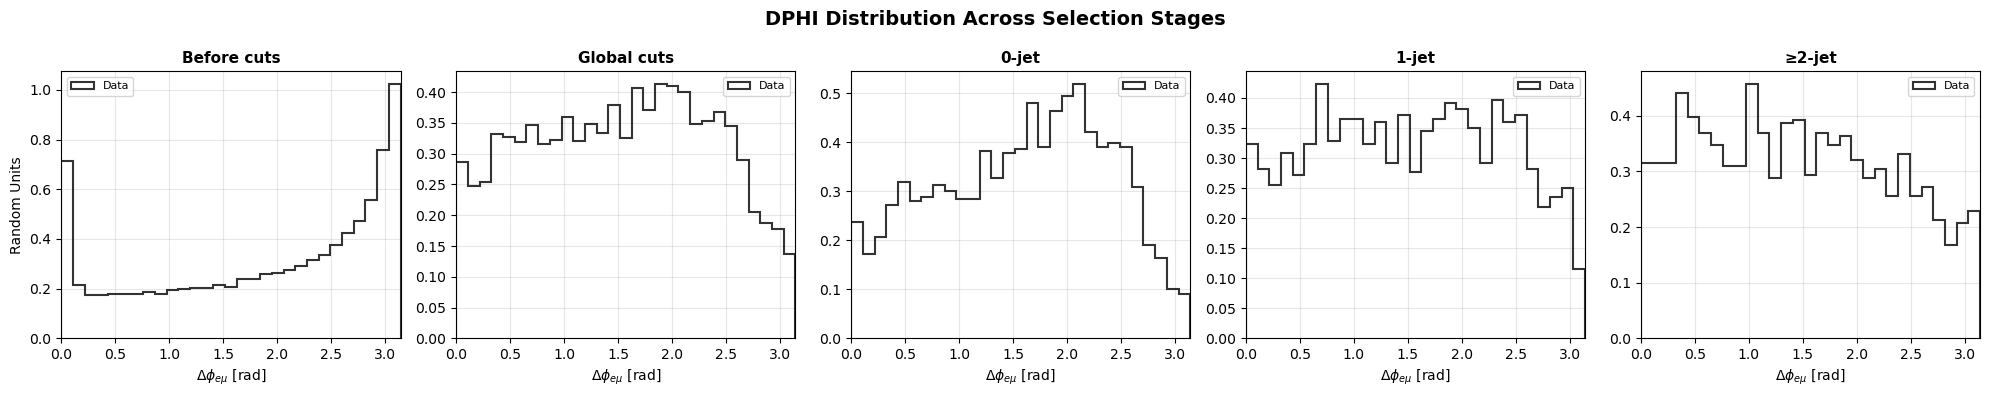


Plotting ptll...


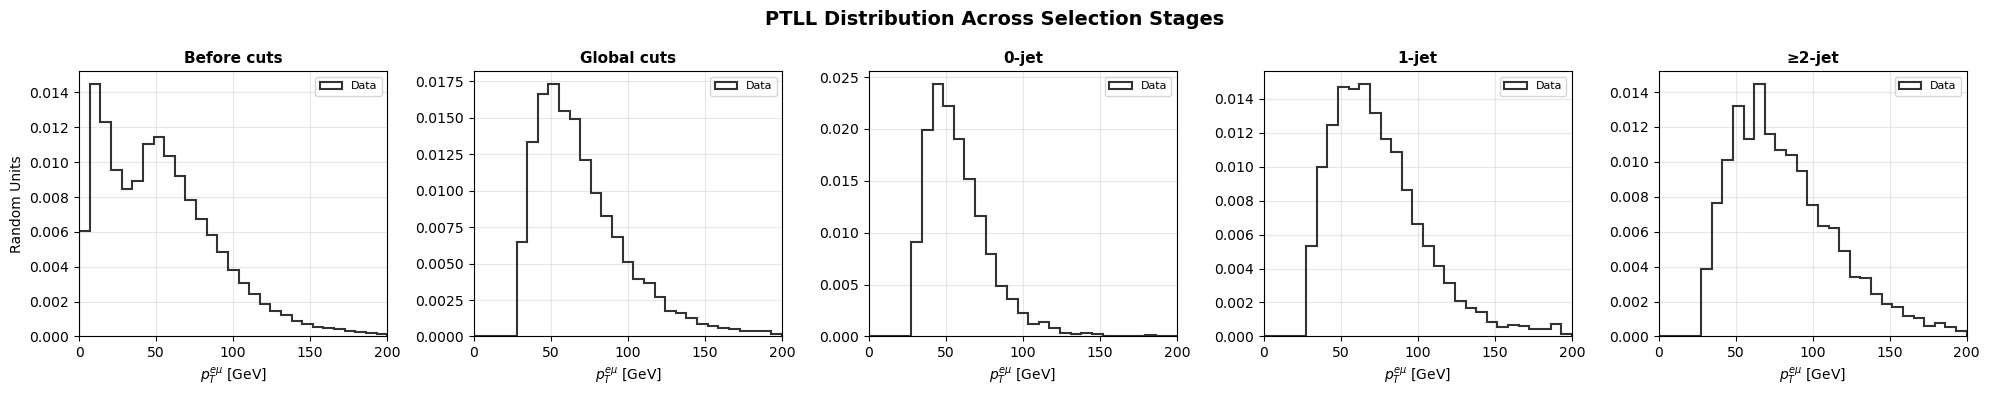


Plotting mt_higgs...


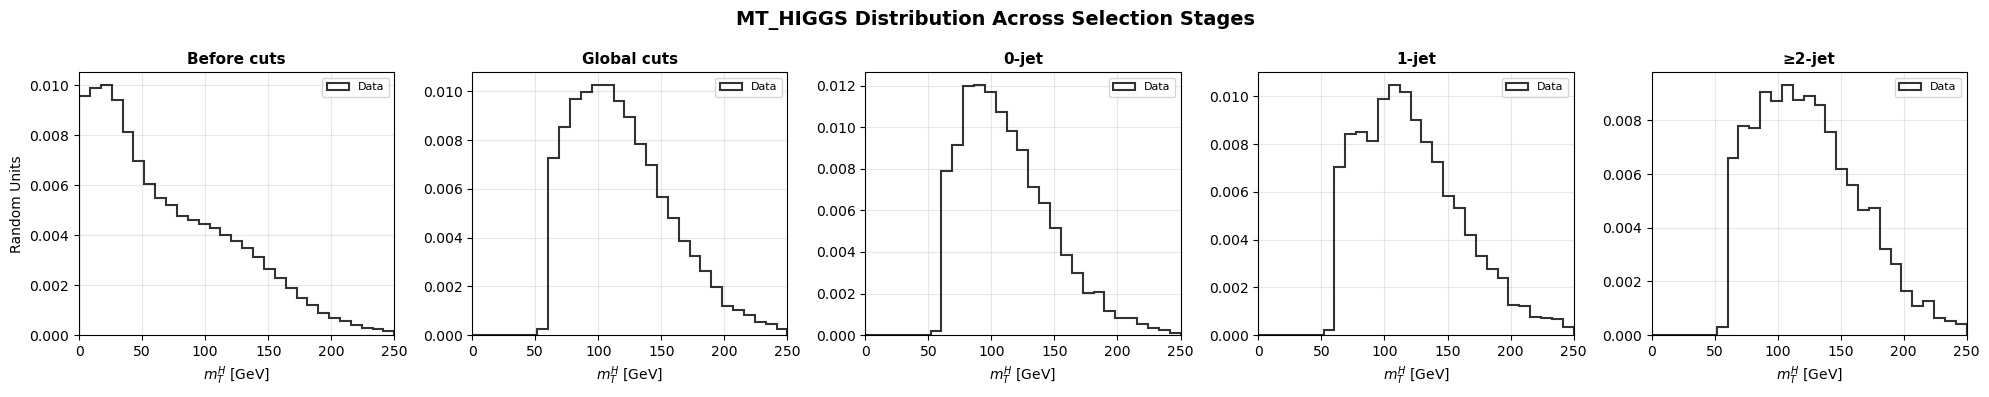


Plotting mt_l2_met...


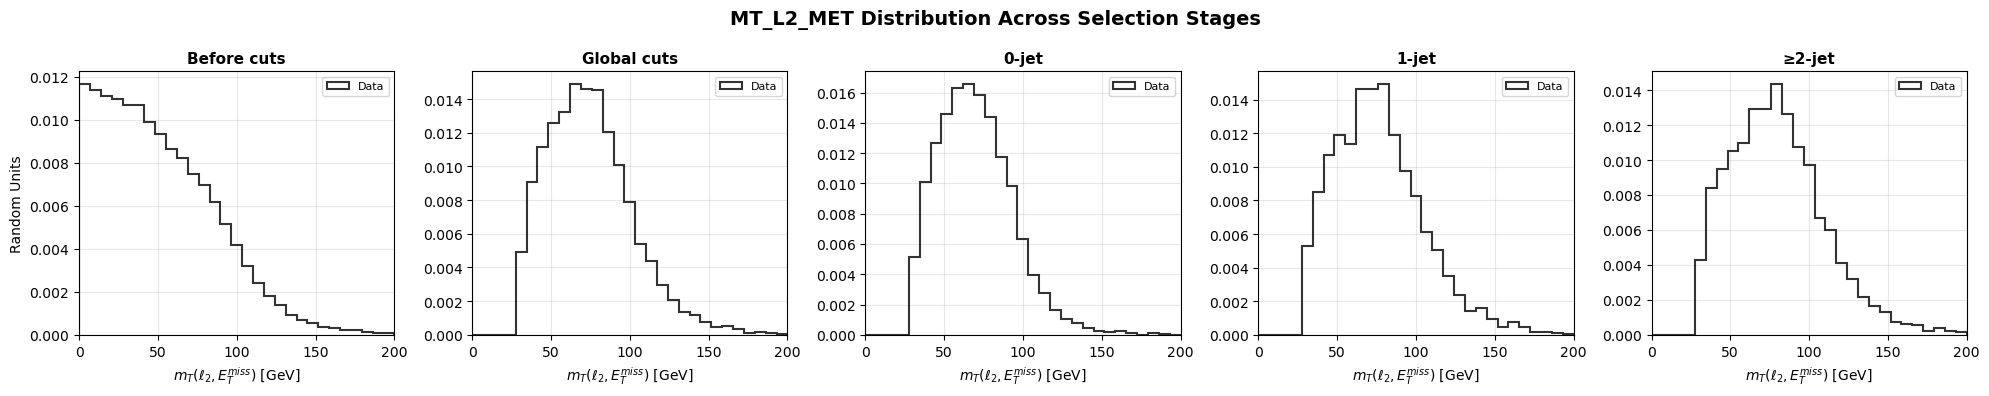

In [64]:
# Plot comparisons for key variables
print("\n" + "="*60)
print("Creating comparison plots...")
print("="*60)

# Plot all variables with signal and backgrounds superimposed
for var_name, var_props in variables_to_plot.items():
    print(f"\nPlotting {var_name}...")
    fig = plot_stage_comparison(var_name, var_props, stage_data_final)
    plt.show()

In [40]:
def get_backgrounds_and_signal():
    """Get ordered backgrounds and signal for plotting"""
    backgrounds = [key for key, props in SAMPLES.items() 
                  if not props["is_signal"] and props["stack_order"] is not None]
    backgrounds.sort(key=lambda x: SAMPLES[x]["stack_order"])
    
    signal = [key for key, props in SAMPLES.items() if props["is_signal"]]
    
    return backgrounds, signal[0] if signal else None

In [41]:
def plot_stage_comparison_stacked(variable, var_props, stage_data_all):
    """Create comparison plot across selection stages with stacked backgrounds and signal, plus signal overlay"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    # Get backgrounds and signal
    backgrounds, signal = get_backgrounds_and_signal()
    
    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        
        # Collect all data (backgrounds + signal for stack)
        stack_data = []
        stack_labels = []
        stack_colors = []
        
        # First add backgrounds
        for bkg in backgrounds:
            if bkg in stage_data_all and stage_data_all[bkg][stage] is not None:
                if variable in stage_data_all[bkg][stage]:
                    data = ak.to_numpy(stage_data_all[bkg][stage][variable])
                    if len(data) > 0:
                        stack_data.append(data)
                        stack_labels.append(bkg)
                        stack_colors.append(SAMPLES[bkg]["color"])
        
        # Then add signal to the stack
        sig_data = None
        if signal and signal in stage_data_all and stage_data_all[signal][stage] is not None:
            if variable in stage_data_all[signal][stage]:
                sig_data = ak.to_numpy(stage_data_all[signal][stage][variable])
                """ adding signal to stack """
                # if len(sig_data) > 0:
                #     stack_data.append(sig_data)
                #     stack_labels.append('Signal (stacked)')
                #     stack_colors.append(SAMPLES[signal]["color"])
        
        # Plot stacked histogram (backgrounds + signal)
        if stack_data:
            ax.hist(stack_data, bins=var_props['bins'], label=stack_labels,
                   color=stack_colors, stacked=True, alpha=1, edgecolor='none')
        
        # Plot signal overlay (outline only)
        if sig_data is not None and len(sig_data) > 0:
            ax.hist(sig_data, bins=var_props['bins'], 
                   histtype='step', linewidth=2.5, 
                   label='Signal (overlay)', color=SAMPLES[signal]["color"],
                   linestyle='-')
        
        ax.set_xlabel(var_props['xlabel'], fontsize=10)
        ax.set_title(stage_label, fontsize=11, fontweight='bold')
        ax.set_xlim(var_props['xlim'])
        ax.set_yscale('log')
        ax.set_ylim(bottom=1)  # minimum y-limit for log scale

        if idx == 0:
            ax.set_ylabel('Events', fontsize=10)
            ax.legend(fontsize=8)
        
        # ax.grid(True, alpha=0.3)

    plt.suptitle(f'{variable.upper()} Distribution Across Selection Stages', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


Creating comparison plots...

Plotting mass...


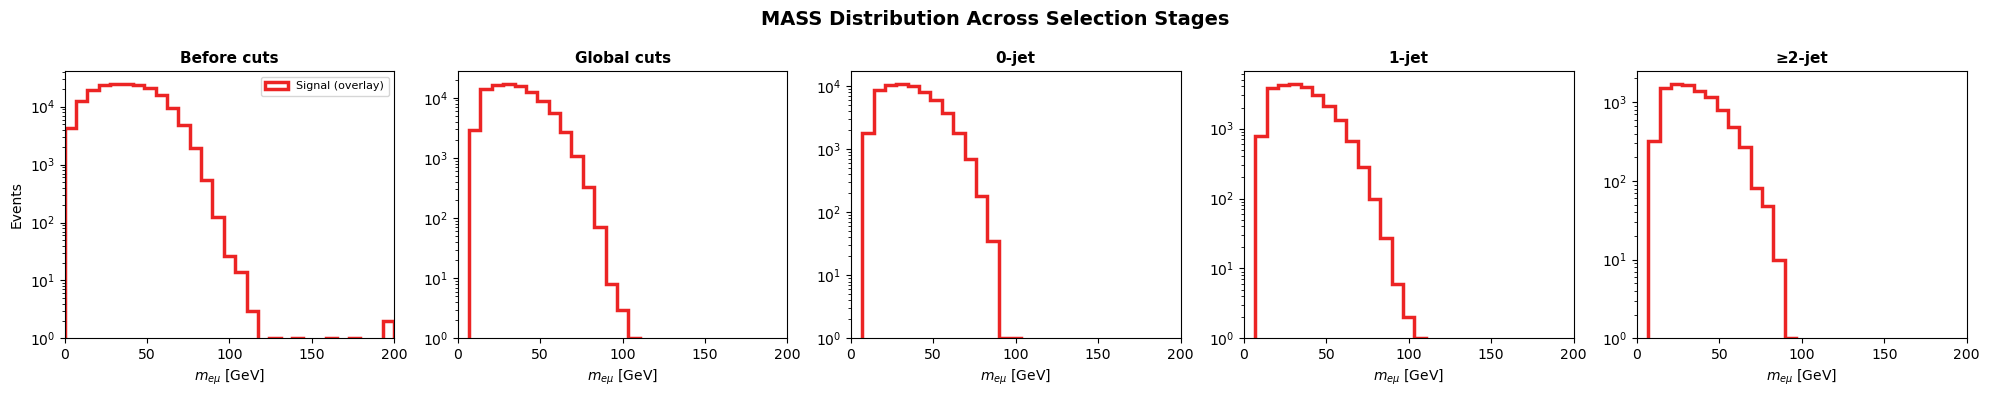


Plotting met...


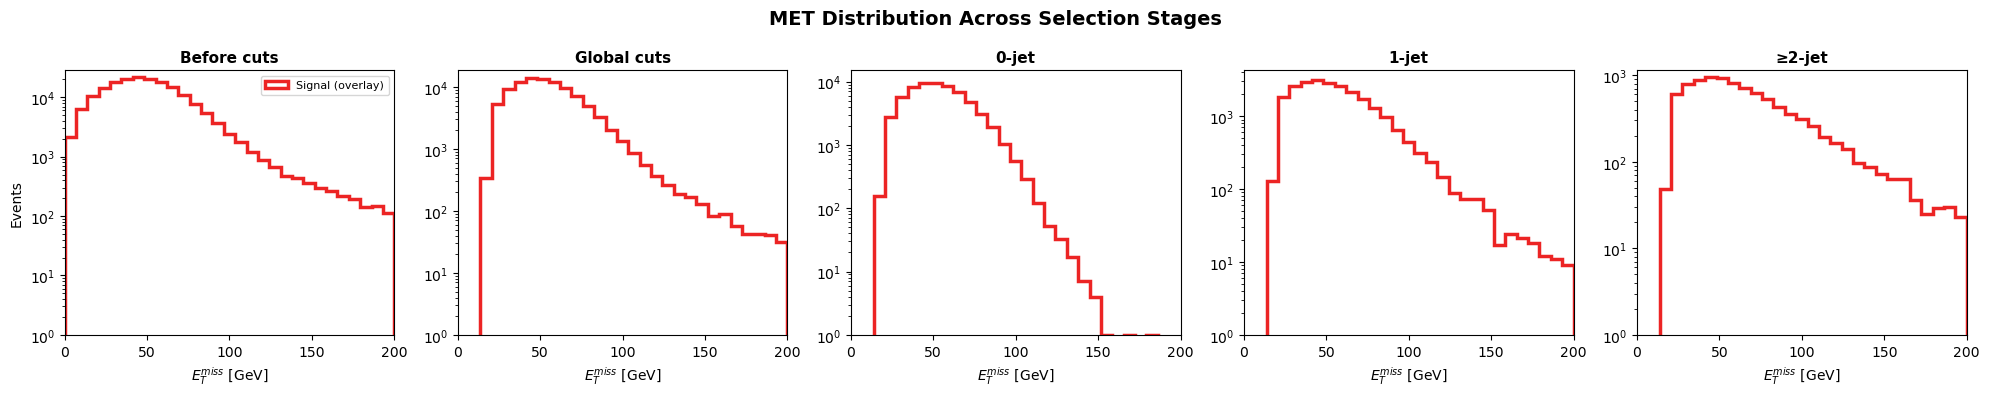


Plotting dphi...


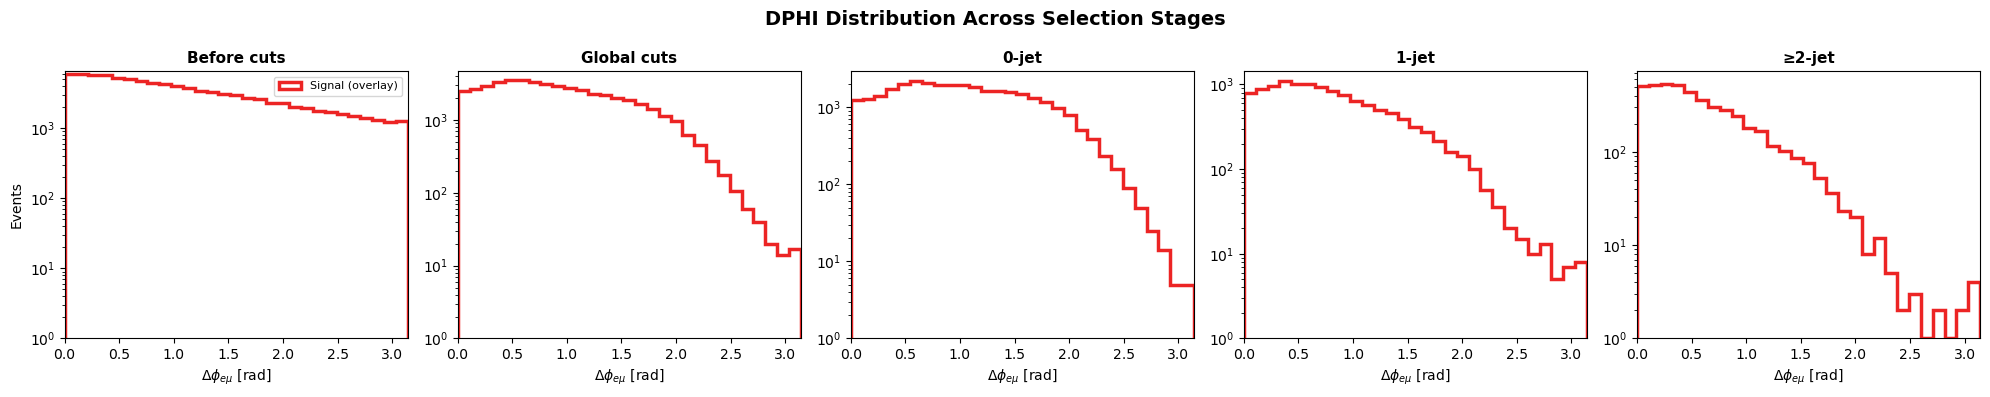


Plotting ptll...


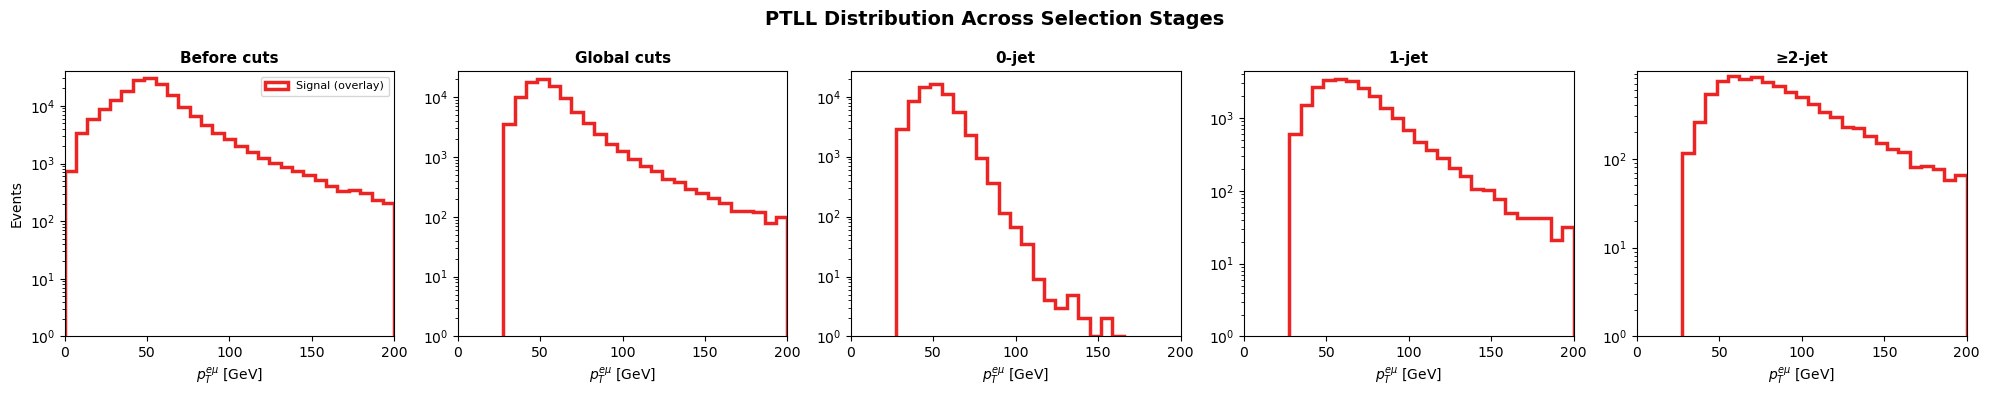


Plotting mt_higgs...


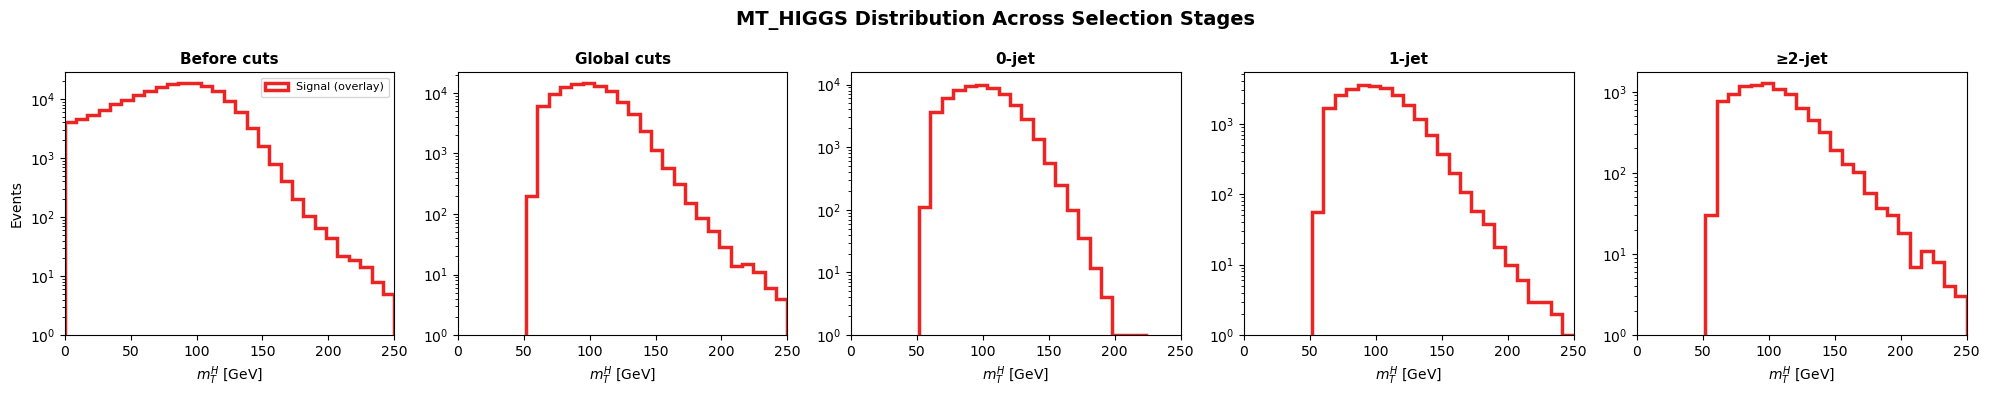


Plotting mt_l2_met...


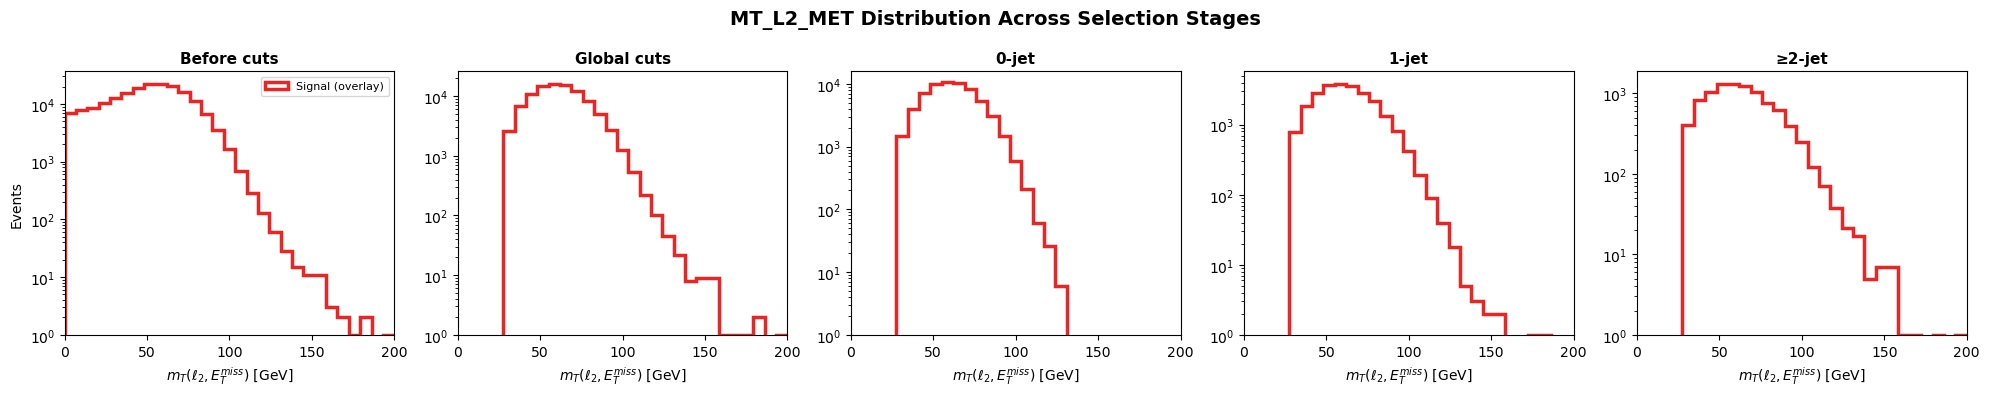

In [42]:
# Plot comparisons with both styles
print("\n" + "="*60)
print("Creating comparison plots...")
print("="*60)

for var_name, var_props in variables_to_plot.items():
    print(f"\nPlotting {var_name}...")
    
    # Step histograms (overlaid)
    # fig1 = plot_stage_comparison(var_name, var_props, stage_data_final)
    # plt.show()
    
    # Stacked backgrounds with signal overlay
    fig2 = plot_stage_comparison_stacked(var_name, var_props, stage_data_final)
    plt.show()

### Cutflow summary

In [43]:
# from prettytable import PrettyTable
# import numpy as np

def print_event_statistics(all_samples_data):
    """Print summary statistics for all samples and stages using PrettyTable."""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Pre-selection cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    
    # print("\n" + "="*90)
    print("EVENT STATISTICS SUMMARY")
    # print("="*90)
    
    # Create PrettyTable for per-sample statistics
    table = PrettyTable()
    table.field_names = ["Sample"] + stage_labels
    table.align = "r"
    table.align["Sample"] = "l"
    
    for sample_label, stages_dict in all_samples_data.items():
        row = [sample_label]
        for stage in stages:
            if (stages_dict[stage] is not None and 
                'mass' in stages_dict[stage]):
                n_events = len(stages_dict[stage]['mass'])
                row.append(f"{n_events:,}")
            else:
                row.append("0")
        table.add_row(row)
    
    print(table)
    # print("="*90)
    
    # # Summary section
    # print("\nSUMMARY:")
    # # print("="*70)
    
    # summary_table = PrettyTable()
    # summary_table.field_names = ["Stage", "Signal", "Background", "S/√B"]
    # summary_table.align = "r"
    # summary_table.align["Stage"] = "l"
    
    # for stage, stage_label in zip(stages, stage_labels):
    #     total_bkg = 0
    #     total_sig = 0
        
    #     for sample_label, sample_props in SAMPLES.items():
    #         if sample_label in all_samples_data:
    #             stage_data = all_samples_data[sample_label][stage]
    #             if stage_data is not None and 'mass' in stage_data:
    #                 n_events = len(stage_data['mass'])
    #                 if sample_props["is_signal"]:
    #                     total_sig += n_events
    #                 else:
    #                     total_bkg += n_events
        
    #     s_over_sqrt_b = total_sig / np.sqrt(total_bkg) if total_bkg > 0 else 0.0
    #     summary_table.add_row([stage_label, f"{total_sig:,}", f"{total_bkg:,}", f"{s_over_sqrt_b:.2f}"])
    
    # print(summary_table)
    # print("="*70)

# Print the statistics
print_event_statistics(stage_data_final)


EVENT STATISTICS SUMMARY
+--------+--------------------+-------------+--------+--------+--------+
| Sample | Pre-selection cuts | Global cuts |  0-jet |  1-jet | ≥2-jet |
+--------+--------------------+-------------+--------+--------+--------+
| signal |            186,418 |      96,943 | 62,980 | 24,515 |  9,448 |
+--------+--------------------+-------------+--------+--------+--------+


---
---
---
---
# Extras
---
---
---
---
---


In [44]:
def plot_overlaid_stages(variable, var_props, all_samples_data):
    """Create overlaid histograms for all stages in single plot per sample"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    stage_colors = ['#666666', '#0066CC', '#00AA44', '#FF9900', '#CC0000']
    stage_styles = ['-', '--', '-.', ':', '-']
    
    # Create subplot for each sample
    n_samples = len(all_samples_data)
    n_cols = min(3, n_samples)
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_samples == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (sample_label, sample_data) in enumerate(all_samples_data.items()):
        ax = axes[idx] if n_samples > 1 else axes[0]
        
        for stage_idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
            if sample_data[stage] is not None and variable in sample_data[stage]:
                data = ak.to_numpy(sample_data[stage][variable])
                
                if len(data) > 0:
                    # Create histogram
                    h = Hist.new.Var(var_props['bins'], name="var").Double()
                    h.fill(var=data)
                    
                    # Plot as step histogram
                    h.plot(ax=ax, histtype="step", 
                          label=f'{stage_label} ({len(data):,})',
                          color=stage_colors[stage_idx],
                          linestyle=stage_styles[stage_idx],
                          linewidth=2, density=True, yerr=False)
        
        ax.set_xlabel(var_props['xlabel'], fontsize=11)
        ax.set_ylabel('Random units', fontsize=11)
        ax.set_title(f'{sample_label}', fontsize=12, fontweight='bold')
        ax.set_xlim(var_props['xlim'])
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplots if any
    for idx in range(n_samples, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle(f'{variable.upper()} Distribution: Stage Comparison', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig



Creating overlaid plot for mass...


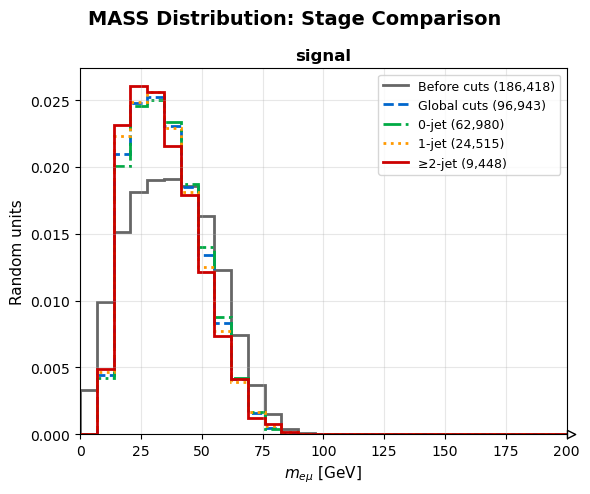


Creating overlaid plot for mt_higgs...


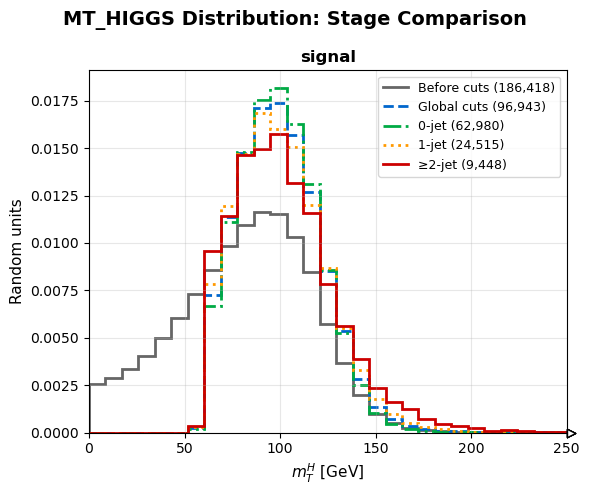


Creating overlaid plot for dphi...


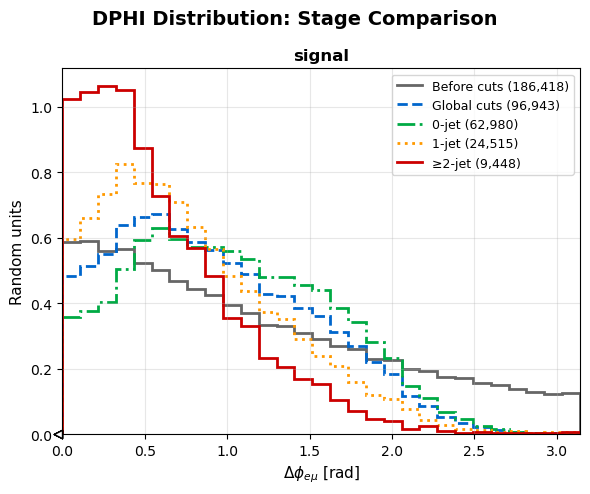


Creating overlaid plot for ptll...


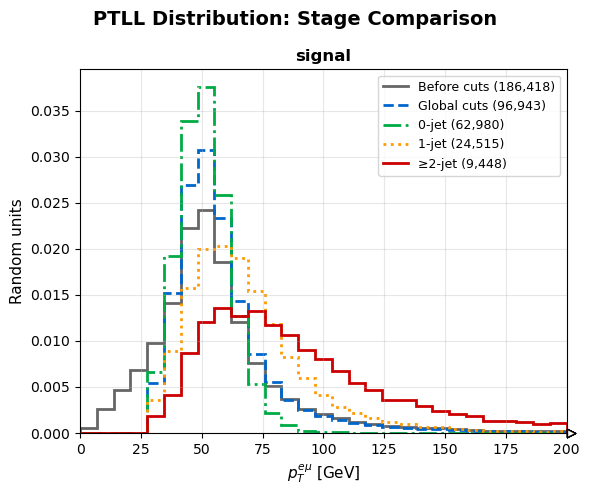


Creating overlaid plot for met...


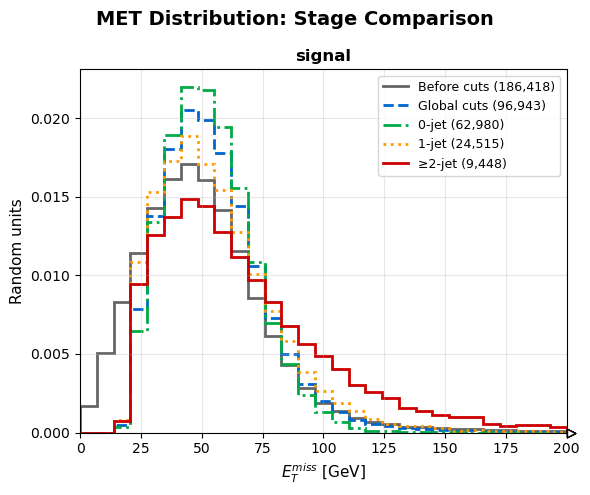


Creating overlaid plot for mt_l2_met...


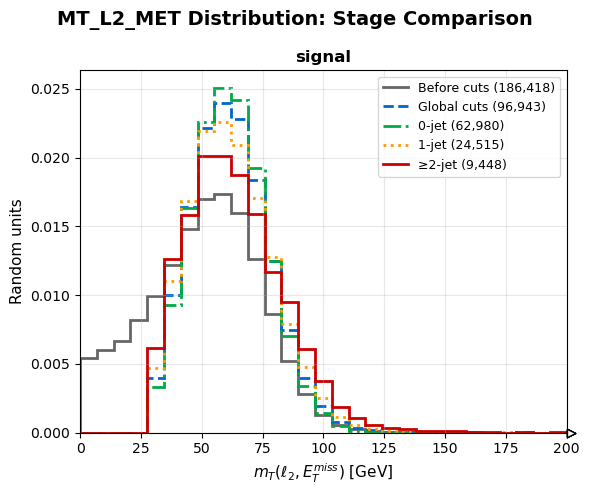

In [45]:
# Create overlaid plots for key variables
key_variables = ['mass', 'mt_higgs', 'dphi','ptll', 'met', 'mt_l2_met']

for var_name in key_variables:
    if var_name in variables_to_plot:
        print(f"\nCreating overlaid plot for {var_name}...")
        fig = plot_overlaid_stages(var_name, variables_to_plot[var_name], 
                                  stage_data_final)
        plt.show()